In [254]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, DataCollatorWithPadding, AutoModelForSequenceClassification, StoppingCriteria

from datasets import DatasetDict, Features, Sequence, Value, load_dataset, ClassLabel

import torch
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
import gc

import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import pandas as pd

from tqdm import tqdm

from sklearn.metrics import classification_report

from src.utils import performance_metrics, plot_confusion_matrix, ms_label2id, ms_id2label

In [2]:
def check_gpu_memory():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        for gpu_id in range(num_gpus):
            free_mem, total_mem = torch.cuda.mem_get_info(gpu_id)
            gpu_properties = torch.cuda.get_device_properties(gpu_id)
            print(f"GPU {gpu_id}: {gpu_properties.name}")
            print(f"   Total Memory: {total_mem / (1024 ** 3):.2f} GB")
            print(f"   Free Memory: {free_mem / (1024 ** 3):.2f} GB")
            print(f"   Allocated Memory : {torch.cuda.memory_allocated(gpu_id) / (1024 ** 3):.2f} GB")
            print(f"   Reserved Memory : {torch.cuda.memory_reserved(gpu_id) / (1024 ** 3):.2f} GB")
    else:
        print("No GPU available.")
# Call the function to check GPU memory
check_gpu_memory()

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 23.43 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


# LLAMA MedTuned 13B

In [3]:
model_name = "Llama2-MedTuned-13b"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Low precision config
print("Memory before Model is loaded:\n")
check_gpu_memory()
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(paths.MODEL_PATH/model_name, 
                                             device_map="auto", 
                                             quantization_config = bnb_config, 
                                            attn_implementation="flash_attention_2",
                                            )
print("Memory after Model is loaded:\n")
check_gpu_memory()

Memory before Model is loaded:

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 23.43 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Memory after Model is loaded:

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 16.42 GB
   Allocated Memory : 6.81 GB
   Reserved Memory : 6.98 GB


In [5]:
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/model_name, padding_side='left')
print("Vocabulary Size without Pad Token: ", len(tokenizer))

# Check if the pad token is already in the tokenizer vocabulary
if '<pad>' not in tokenizer.get_vocab():
    # Add the pad token
    tokenizer.add_special_tokens({"pad_token":"<pad>"})

#Resize the embeddings
model.resize_token_embeddings(len(tokenizer))

#Configure the pad token in the model
model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.config.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)
print("Vocabulary Size with Pad Token: ", len(tokenizer))

Vocabulary Size without Pad Token:  32000
Tokenizer pad token ID: 32000
Model pad token ID: 32000
Model config pad token ID: 32000
Vocabulary Size with Pad Token:  32001


In [77]:
# Llama-2 chat template
base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>{user_input}[/INST] \n\nBased on the information provided in the text, the patient's diagnosis can be classified as"
system_prompt =  ("You are a specialized medical language processor for German medical reports. "
                  "Users will present you with medical reports in German and request the extraction of specific diagnostic information. "
                  "Your responses should be concise, as short as possible and based solely on the information available in the input text. "
                  "If the required information is not present, explicitly mention it."
                 )
task_instruction = ("Your task is to repeat the type of multiple Sclerosis (MS) stated in a medical report. There are 3 types: "
                    "primary progressive MS, secondary progressive MS and relapsing remitting MS) "
                    "Here are the German translations of these types: primary progressive multiple sclerosis = primär progrediente Multiple Sklerose"
                    ", secondary progressive multiple sclerosis = sekundär progrediente Multiple Sklerose, relapsing remitting multiple sclerosis = schubförmig remittierende Multiple Sklerose."
                    "The type is provided in the text you just have to repeat it. If you can't find mentions of a type in the text "
                    "answer with \"no multiple sclerosis\". "
                    "Your answer should solely consist of either \"primary progressive multiple sclerosis\", \"secondary progressive multiple sclerosis\" "
                    "\"relapsing remitting multiple sclerosis\", or \"no multiple sclerosis\"."
                    "Here is the medical report: "
                   )
def format_prompt(user_input):
    input = base_prompt.format(system_prompt = system_prompt,
                               user_input =  task_instruction  + user_input)
    return tokenizer(input, return_tensors = "pt")

In [7]:
# Trying to make output more consistent by stopping on MS, https://github.com/huggingface/transformers/issues/26959
class EosListStoppingCriteria(StoppingCriteria):
    def __init__(self, eos_sequence = [835, 2799, 4080, 29901]):
        self.eos_sequence = eos_sequence

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_ids = input_ids[:,-len(self.eos_sequence):].tolist()
        return self.eos_sequence in last_ids
ms_stop = EosListStoppingCriteria(tokenizer("multiple sclerosis", add_special_tokens = False)["input_ids"])

## Zero Shot

In [260]:
# Llama-2 chat template
paper_base_prompt = "<s>[INST]### Instruction: {instruction} ### Input: {user_input} ### Output: [/INST]"
task_instruction = ("Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
                    "primär progrediente Multiple Sklerose (PPMS), sekundär progrediente Multiple Sklerose (SPMS) and schubförmige Multiple Sklerose (RRMS)."
                    "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
                    "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
                    "\schubförmige Multiple Sklerose (RRMS)\", or \"not enough info\"."
                    "Here is the medical report: "
                   )
def format_paper_prompt(user_input):
    input = paper_base_prompt.format(instruction = task_instruction, user_input =  user_input)
    return tokenizer(input, return_tensors = "pt")

In [390]:
label_mapping = {
    'primary progressive': 'primary_progressive_multiple_sclerosis',
    'secondary progressive': 'secondary_progressive_multiple_sclerosis',
    'relapsing remitting': 'relapsing_remitting_multiple_sclerosis',
    'no multiple sclerosis': 'no_ms'
}

label_mapping2 = {
    'ppms': 'primary_progressive_multiple_sclerosis',
    'primär': 'primary_progressive_multiple_sclerosis',
    'sekundär': 'secondary_progressive_multiple_sclerosis',
    'spms': 'secondary_progressive_multiple_sclerosis',
    'rrms': 'relapsing_remitting_multiple_sclerosis',
    'schubförmig': 'relapsing_remitting_multiple_sclerosis',
    'not enough info': 'no_ms'
}

def map_strings_to_labels(input_string):
    input_lower = input_string.strip().lower()
    
    first_match_key = None
    first_match_index = float('inf')  # Set to positive infinity initially
    
    for key in label_mapping2.keys():
        index = input_lower.find(key)
        if index != -1 and index < first_match_index:
            first_match_key = key
            first_match_index = index
    label = label_mapping2.get(first_match_key, None) if first_match_key else None
    return ms_label2id.get(label, -99)

def zero_shot_inference(data, format_fun, answer_prefix, max_new_tokens:int = 100):

    obs_list = []
    

    for i in tqdm(range(len(data))):
        example = data[i]
        
        prompt_encoded = format_fun(example["text"])
        
        # Use model.generate with torch.no_grad() for inference
        with torch.no_grad():
            return_tokens = model.generate(
                **prompt_encoded,
                max_new_tokens=max_new_tokens,
                temperature=1,
                top_p=1,
                do_sample=False,
                #stopping_criteria=[ms_stop]
            )

        result = tokenizer.batch_decode(return_tokens, skip_special_tokens=True)[0]        
        result = result.split(answer_prefix)[-1].strip()
        
        example["result"] = result
        example["preds"] = int(map_strings_to_labels(result))
        obs_list.append(example)

    # Fix the DataFrame creation
    return pd.DataFrame(obs_list)

In [262]:
# Load data
df_line = DatasetDict.load_from_disk(os.path.join(paths.DATA_PATH_PREPROCESSED, "ms-diag/ms_diag_line"))

In [249]:
df_line_test = zero_shot_inference(df_line["test"].filter(lambda e: e["labels"] != 3), format_fun = format_paper_prompt, answer_prefix = "### Output: [/INST]")

  0%|          | 0/46 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 46/46 [01:11<00:00,  1.55s/it]


In [266]:
df_line_test.to_csv(paths.RESULTS_PATH/"ms-diag/ms-diag_llama2-MedTuned_clm_line_paper-prompt_original_test.csv")

In [258]:
df_line_no_dm_test = zero_shot_inference(df_line["test"].filter(lambda e: e["labels"] == 3).select(range(30)), format_fun = format_paper_prompt, answer_prefix = "### Output: [/INST]")

  0%|          | 0/30 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


In [267]:
df_line_no_dm_test.to_csv(paths.RESULTS_PATH/"ms-diag/ms-diag_llama2-MedTuned_clm_line_paper-prompt_no-dm_test.csv")

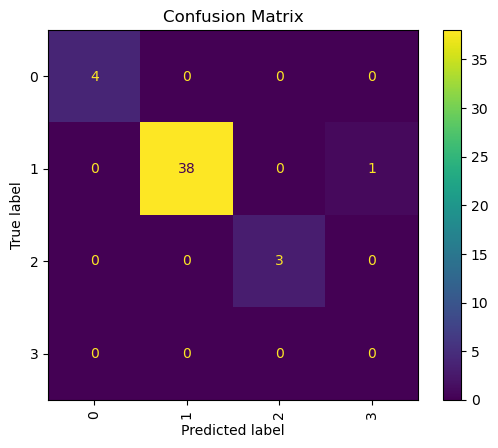

In [264]:
plot_confusion_matrix(df_line_test["preds"], df_line_test["labels"])

In [265]:
print(classification_report(df_line_test["preds"], df_line_test["labels"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.97      1.00      0.99        38
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         1

    accuracy                           0.98        46
   macro avg       0.74      0.75      0.75        46
weighted avg       0.96      0.98      0.97        46



/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [268]:
# Load data
df_all = DatasetDict.load_from_disk(os.path.join(paths.DATA_PATH_PREPROCESSED, "ms-diag/ms_diag_all"))

In [269]:
df_all_paper_prompt_test = zero_shot_inference(df_all["test"], format_fun = format_paper_prompt, answer_prefix = "### Output: [/INST]")

  0%|          | 0/58 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 58/58 [02:06<00:00,  2.18s/it]


In [271]:
df_all_paper_prompt_test.to_csv(paths.RESULTS_PATH/"ms-diag/ms-diag_llama2-MedTuned_clm_all_paper-prompt_test.csv")

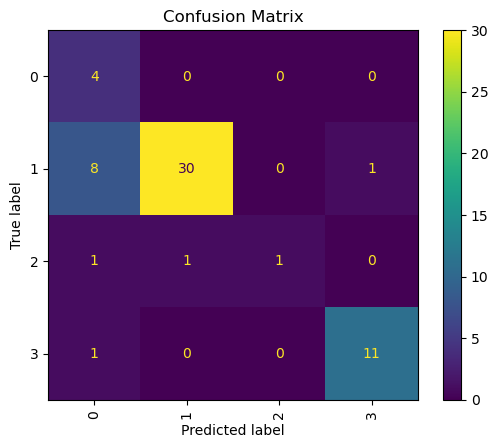

In [272]:
plot_confusion_matrix(df_all_paper_prompt_test["preds"], df_all_paper_prompt_test["labels"])

In [273]:
performance_metrics(df_all_paper_prompt_test["preds"], df_all_paper_prompt_test["labels"])

{'accuracy': 0.7931034482758621,
 'f1': 0.6795634920634921,
 'precision': 0.7925307219662058,
 'recall': 0.7548076923076923}

In [274]:
df_all_paper_prompt_test[df_all_paper_prompt_test["preds"] != df_all_paper_prompt_test["labels"]]

,rid,text,labels,result,preds
4,83D5B33F-2967-40C9-BA12-7173CF6C1BE0,"Multiple Sklerose, schubförmiger Verlauf (EM 2006, ED 06.08.2014)\nINDENT Verlauf:\nINDENT 2006: Koordinationsstörung der rechten Körperhälfte\nINDENT 05/2014 Parästhesien der Extemitäten li>re und Gesicht seit 05/2014\nINDENT Diagnostik\nINDENT laborchemisch 10/06: TSH, MAJ, TAK, Eiweisselektrophorese, C3- C4 Komplement, ACE normal\nINDENT Serologie 10/06: Coxsackie-Virus- AL der Serotypen 1,...",1,primär progrediente Multiple Sklerose (PPMS),0
14,DFC51E69-4E29-467F-AF71-BBFE79F6778D,"Entzündliche ZNS-Erkrankung, EM 03/2016\nINDENT anamnestisch: vor ca. 4 Wochen Symptombeginn mit Schwankschwindel, verstärkt beim Blick nach rechts und oben, Gangunsicherheit, Entwicklung von Lichtempfindlichkeit, aktuell Schwindelsymptomatik vollständig regredient\nINDENT klinisch: fokal-neurologisch unauffällig\nINDENT diagnostisch: \nINDENT MRI Schädel vom 09.03.2016 (extern): keilförmige T...",3,primär progrediente Multiple Sklerose (PPMS),0
23,C2232083-842D-42B2-A7DA-7D9EB4081C4B,"Schubförmig verlaufende Multiple Sklerose, Erstmanifestation 10/2010, Erstdiagnose 02/2012 mit/bei:\nINDENT MRI-Schädel 01/2012: 5 T2-Läsionen supra- und infratentoriell, Läsion im Bereich des Lemniscus medialis sowie 16 mm messende Läsion im Verlauf des Nervus abducens\nINDENT MRI cerebral und spinal 01/2013 und 04/2014, cMRI 01/2015: stabiler Befund, keine KM-Aufnahme\nINDENT 03/2017 cMRI: 2...",1,primär progrediente Multiple Sklerose (PPMS),0
25,96BC21AA-235F-4EED-A74F-58EFC11C1176,"Hochgradiger V.a. entzündliche ZNS-Erkrankung ED 03.05.2019, EM 30.04.2019\nINDENT ätiologisch: möglicherweise multiple Sklerose\nINDENT anamnestisch: seit 4 Tagen aufsteigende Dysästhesie von den Füssen bis etwa T12, distal betont; St. n. Atemwegsinfektion vor einigen Tagen\nINDENT klinisch: Dysästhesie sub Th12, Hypopallästhesie malleolar bds 7/8, Lagesinn und Temperatursinn erhalten, keine...",1,not enough info,3
27,F87876FA-3068-4A93-AE71-6071CBE5F1F2,"Entzündliche ZNS-Erkrankung, möglicherweise Multiple Sklerose vom schubförmig-remittierenden Verlaufstyp (ED 12/2015 Spital Linth)\nINDENT anamnestisch: aktuell seit heute stechende Schmerzen der Oberschenkel, zudem Kraftlosigkeit und Kopfschmerzen\nINDENT klinisch: bei Eintritt und Austritt dissoziierte Sensibilitätsstörung sub Th10 bds. (Thermhypalgesie und Hyperästhesie), lebhaft auslösbare...",1,primär progrediente Multiple Sklerose (PPMS),0
29,0FA0E814-EFF9-4888-8410-C27659833E25,"1. Sekundär progrediente schubförmige Multiple Sklerose, EM ca. 1993, ED 08/2004 EDSS 4.0\nklinisch nicht aktiv, radiologisch aktiv, sekundäre Progredienz seit 2013 (nach Lublin et al. 2013)\nKlinisch:\nVisus links 0,1, rechts 0,4, deutlicher Endstellnystagmus, sakkadierte Blickfolge, Bradydiadochokinese rechts, beinbetonte Hypästhesie, rechts betont\nVerlauf: \n1993 Sehstörung des linken Auge...",1,primär progrediente Multiple Sklerose (PPMS),0
33,189A2297-8248-470D-8378-66B37264856C,"1. Schubförmige Multiple Sklerose (RRMS) (EM 1994, ED 1995), EDSS 6.5\nDD sekundär progredienter Verlauf mit aufgesetzten Schüben\nAktuell: klinisch: stabil, radiologisch: geringe Aktivität, Progression: ja (nach Lublin et al. 2013)\nKlinisch: Visusminderung 0.4 rechts, linke 0.8, spastische Paraparese der Beine links > rechts; Hypästhesie bds sub Th10/11, sowie Halsbereich rechts; Patient bis...",1,primär progrediente Multiple Sklerose (PPMS),0
43,CACC4AEC-E2E4-429E-8697-5FC53727E31A,"Schubförmige, unvollständig remittierende Multiple Sklerose mit sekundär progredientem Verlauf, EM 2007, ED 2010, EDSS 6.5\nINDENT aktuell: klinisch: nicht aktiv, radiologisch: nicht aktiv, Progression: ja (nach Lublin et al. 2013)\nanamnestisch: zunehmende Einschränkung der Gehfähigkeit mit deutlicher Progredienz seit 2017\nklinisch: rechts- und beinbetonte Tetraparese (Arm distal betont), üb...",2,"schubförmige, unvollständig remittierende Multiple Sklerose mit sekundär progredientem Verlauf",1
44,54FBE2C1-4F4A-4E43

## Few Shot

In [361]:
# Llama-2 chat template

fewshot_base_prompt = "<s>[INST]### Instruction: {instruction}{examples} ### Input: {user_input} ### Output: [/INST]"
task_instruction = ("Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
                    "primär progrediente Multiple Sklerose (PPMS), sekundär progrediente Multiple Sklerose (SPMS) and schubförmige Multiple Sklerose (RRMS)."
                    "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
                    "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
                    "\schubförmige Multiple Sklerose (RRMS)\", or \"not enough info\"."
                   )
id2label_map = {
    0: "primär progrediente Multiple Sklerose (PPMS)",
    1: "schubförmige Multiple Sklerose (RRMS)",
    2: "sekundär progrediente Multiple Sklerose (SPMS)",
}

def format_examples(examples):
    input = ""
    for example in examples:
        text = example["text"]
        label = id2label_map[example["labels"]]
        input += f"### Input: {text} ### Output: {label}\n"
    return input
    
def format_fewshot_prompt(user_input, examples):
    examples = format_examples(examples)
    input = fewshot_base_prompt.format(instruction = task_instruction, examples = examples, user_input = user_input)
    return tokenizer(input, return_tensors = "pt")

In [362]:
def few_shot_inference(data, format_fun, answer_prefix, format_fun_kwargs:dict = {}, max_new_tokens:int = 100):

    obs_list = []
    

    for i in tqdm(range(len(data))):
        example = data[i]
        
        prompt_encoded = format_fun(user_input = example["text"], **format_fun_kwargs)
        
        # Use model.generate with torch.no_grad() for inference
        with torch.no_grad():
            return_tokens = model.generate(
                **prompt_encoded,
                max_new_tokens=max_new_tokens,
                temperature=1,
                top_p=1,
                do_sample=False,
            )

        result = tokenizer.batch_decode(return_tokens, skip_special_tokens=True)[0]        
        result = result.split(answer_prefix)[-1].strip()
        
        example["result"] = result
        example["preds"] = int(map_strings_to_labels(result))
        obs_list.append(example)

    # Fix the DataFrame creation
    return pd.DataFrame(obs_list)

In [363]:
example_ppms = df_line["train"].filter(lambda e: e["labels"] == 0)[0]
example_spms = df_line["train"].filter(lambda e: e["labels"] == 2)[0]
example_rrms = df_line["train"].filter(lambda e: e["labels"] == 1)[3]

In [364]:
df_all_few_shot = few_shot_inference(df_all["test"], 
                    format_fun = format_fewshot_prompt, 
                    answer_prefix = "### Output: [/INST]",
                    format_fun_kwargs = {"examples": [example_ppms, example_spms, example_rrms]},
                    max_new_tokens = 50)

  0%|          | 0/58 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 58/58 [02:50<00:00,  2.93s/it]


In [365]:
df_all_few_shot

,rid,text,labels,result,preds
0,55E636B5-EA14-497D-832B-A87444F3C096,"Schubförmige Multiple Sklerose (EM, ED 12/2005), EDSS 1.0\nklinisch fraglich aktiv, radiologisch aktiv, keine Progression (nach Lubin et al. 2013)\nklinisch aktuell: Verschwommensehen bds angegeben, Schwankschwindel angegeben, sonst kein fokal-neurologisches Defizit\nVerlauf:\n12/2005 Hemisyndrom links, Dysarthrie, Dysästhesie\n04/2014 Optikusneuritis rechts \n10/2017 sensibles Hemisyndrom lin...",1,This is a case of relapsing remitting multiple sclerosis (RRMS) with secondary progressive multiple sclerosis (SPMS) features.,1
1,CE90E38D-BBBF-4F7B-98E0-B87EE0E6DFCE,"Schubförmige Multiple Sklerose, EM 05/2018, ED 07/2018\nINDENT EDSS 0.0\nINDENT Aktuell: klinisch nicht aktiv, radiologisch nicht aktiv, keine Progression (nach Lublin 2013)\nINDENT Verlauf: \nINDENT 03.05.2018: Kribbelparästhesie im linken Fuss dorsalseitig und plantar, sowie intermittierend (< 24h) im linken Unterschenkel und im Verlauf linke palmare Handfläche\nINDENT 29.06.2018: Kribbelpar...",1,The type of multiple sclerosis (MS) stated in the German medical report is: schubförmige Multiple Sklerose (RRMS).,1
2,B0B07B18-0211-4467-8489-581AC761D297,"Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0\naktuell: klinisch: stabil, radiologisch: stabil, Progression: ja (nach Lublin et al. 2013)\nINDENT Besserung der Kraft im linken Bein. Probleme beim Laufen, leichte Urge-Symptomatik und gelegentliche Einschlafprobleme. Klinisch spastisch-ataktisches Gangbild mit linksbetonter Spastik in den UE, beidseits gesteigerter ...",0,primär progrediente Multiple Sklerose (PPMS),0
3,69273DEA-ACAC-40CD-8F02-840EB3CC2027,"Schubförmig-remittierende Multiple Sklerose, EM und ED 04/2007\nINDENT Diagnostik\nINDENT EDSS 05/2019: 2.0\nINDENT MRI-Neuroachse 08/2018: Intrakraniell sowie spinal kein Nachweis von neuen oder KM-aufnehmenden Läsionen\nINDENT MRI Schädel vom 08/2013: 1 neue gliotische Läsion im Übergang Mittelhirn zu oberem Kleinhirnschenkel der linken Seite\nINDENT MRI Neuroachse vom 09/2012: Fraglich neue...",1,"Hello, The report states that the patient has a schub-like multiple sclerosis (RRMS). The patient has been treated with several disease-modifying therapies including Interferon beta, Tecfidera",1
4,83D5B33F-2967-40C9-BA12-7173CF6C1BE0,"Multiple Sklerose, schubförmiger Verlauf (EM 2006, ED 06.08.2014)\nINDENT Verlauf:\nINDENT 2006: Koordinationsstörung der rechten Körperhälfte\nINDENT 05/2014 Parästhesien der Extemitäten li>re und Gesicht seit 05/2014\nINDENT Diagnostik\nINDENT laborchemisch 10/06: TSH, MAJ, TAK, Eiweisselektrophorese, C3- C4 Komplement, ACE normal\nINDENT Serologie 10/06: Coxsackie-Virus- AL der Serotypen 1,...",1,primär progrediente Multiple Sklerose (PPMS),0
5,745DA433-83BC-48B0-889D-9578F7F7C3D8,"Primär chronisch progrediente Multiple Sklerose (PPMS), EM 03/2017, ED 08/2017, EDSS 6.0\nINDENT aktuell(10.04.19): \nINDENT anamnestisch: seit 1 Woche bestehende Verschlechterung des Allgemeinzustands, Patient berichtet über Fatigue und allgemeine Schwäche. Ausserdem sei er verlangsamt beim Sprechen und bei körperlichen Aktivitäten, hierbei auch Schwindel. Leichte Visusverschlechterung li>re ...",0,primär progrediente Multiple Sklerose (PPMS),0
6,62278320-172E-4D59-AE84-4F28A2ED877D,"Schubförmige Multiple Sklerose (EM und ED 05/2013), EDSS 2.0\nINDENT Klinisch: Nicht aktiv; radiologisch: Nicht aktiv; Progression: Nein (Lublin, 2013)\nINDENT Aktuell: residuell dezente Hypästhesie der rechten Körperhälfte, Hypakusis rechts\nINDENT Verlauf:\nINDENT 05/2013: Erstmanifestation mit Optikusneuritis rechts\nINDENT 05/2013: Rezidivierende kurzzeitige Episoden mit Schwindel \nINDENT...",1,primär progrediente Multiple Sklerose (PPMS),0
7,33DECF96-0B6A-4B63-A673-F3BEE45D2424,Ophthalmologische Diagnosen\nINDENT OU Myopie,3,"Hi, I have gone through your question and understand your concern. Ophthalmological diagnoses INDENT OU Myopie does not give any information about the

In [366]:
df_all_few_shot.to_csv(paths.RESULTS_PATH/"ms-diag/ms-diag_llama2-MedTuned_clm_all_few-shot_test.csv")

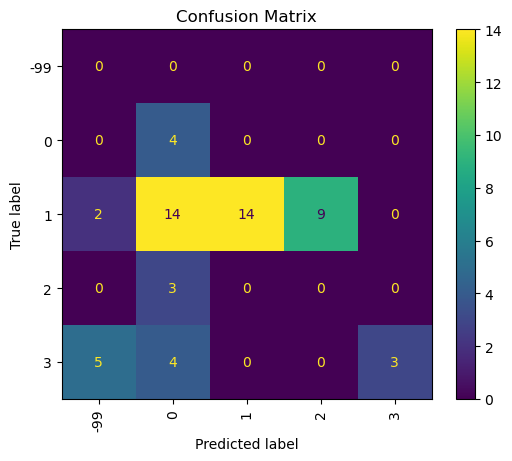

In [367]:
plot_confusion_matrix(df_all_few_shot["preds"], df_all_few_shot["labels"])

In [299]:
zero_shot_inference(df_all["train"].filter(lambda e: e["labels"] != 3).select(range(2)), 
                    format_fun = format_cot_prompt, 
                    answer_prefix = "### Output: [/INST]", 
                    max_new_tokens = 300)

  0%|          | 0/2 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


,rid,text,labels,result,preds
0,CB96C8EB-8D90-4D3A-B9D1-F02F1AD11377,"Sekundär chronisch progrediente1 Multiple Sklerose (SPMS) ab ca. 2011, EM 06/2006, ED 2006, EDSS 6.5\nINDENT ktuell: klinisch: nicht aktiv, radiologisch stabil, keine Progression (nach Lublin et al. 2013)\nINDENT klinisch: rechtsbetonte Paraparese und -spastik der Beine mit Fussheberparese rechtsbetont und deutlich spastisch-ataktischer Gangstörung nur an konstant 2 Gehstöcken möglich, Hyperhi...",2,primär progrediente Multiple Sklerose (PPMS),0
1,920241EB-EF90-40BC-9F5A-2D64CBA63FCC,"Schubförmige Multiple Sklerose, EM 2014, ED 08/2019\nINDENT anamnestisch/klinisch: kognitive Defizite, Pollakisurie\nINDENT EDSS 4.0 Punkte\nINDENT Verlauf:\nINDENT 11/2009 Kopfschmerzen und Fieber, Besserung auf Antibiotika. Folgend immer wieder Kopfschmerzen, phasenweise intensiv, mit brennenden Schmerzen in den Augen und undeutlichem Sehen bds. zusätzlich verwaschene Sprache für wenige Tage...",1,"Based on the information provided the answer is: schubförmige Multiple Sklerose, EM 2014, ED 08/2019",1


In [359]:
df_all_few_shot

,rid,text,labels,result,preds
0,55E636B5-EA14-497D-832B-A87444F3C096,"Schubförmige Multiple Sklerose (EM, ED 12/2005), EDSS 1.0\nklinisch fraglich aktiv, radiologisch aktiv, keine Progression (nach Lubin et al. 2013)\nklinisch aktuell: Verschwommensehen bds angegeben, Schwankschwindel angegeben, sonst kein fokal-neurologisches Defizit\nVerlauf:\n12/2005 Hemisyndrom links, Dysarthrie, Dysästhesie\n04/2014 Optikusneuritis rechts \n10/2017 sensibles Hemisyndrom lin...",1,No multiple sclerosis,-99
1,CE90E38D-BBBF-4F7B-98E0-B87EE0E6DFCE,"Schubförmige Multiple Sklerose, EM 05/2018, ED 07/2018\nINDENT EDSS 0.0\nINDENT Aktuell: klinisch nicht aktiv, radiologisch nicht aktiv, keine Progression (nach Lublin 2013)\nINDENT Verlauf: \nINDENT 03.05.2018: Kribbelparästhesie im linken Fuss dorsalseitig und plantar, sowie intermittierend (< 24h) im linken Unterschenkel und im Verlauf linke palmare Handfläche\nINDENT 29.06.2018: Kribbelpar...",1,No multiple sclerosis,-99
2,B0B07B18-0211-4467-8489-581AC761D297,"Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0\naktuell: klinisch: stabil, radiologisch: stabil, Progression: ja (nach Lublin et al. 2013)\nINDENT Besserung der Kraft im linken Bein. Probleme beim Laufen, leichte Urge-Symptomatik und gelegentliche Einschlafprobleme. Klinisch spastisch-ataktisches Gangbild mit linksbetonter Spastik in den UE, beidseits gesteigerter ...",0,primary progressive multiple sclerosis,-99
3,69273DEA-ACAC-40CD-8F02-840EB3CC2027,"Schubförmig-remittierende Multiple Sklerose, EM und ED 04/2007\nINDENT Diagnostik\nINDENT EDSS 05/2019: 2.0\nINDENT MRI-Neuroachse 08/2018: Intrakraniell sowie spinal kein Nachweis von neuen oder KM-aufnehmenden Läsionen\nINDENT MRI Schädel vom 08/2013: 1 neue gliotische Läsion im Übergang Mittelhirn zu oberem Kleinhirnschenkel der linken Seite\nINDENT MRI Neuroachse vom 09/2012: Fraglich neue...",1,No multiple sclerosis,-99
4,83D5B33F-2967-40C9-BA12-7173CF6C1BE0,"Multiple Sklerose, schubförmiger Verlauf (EM 2006, ED 06.08.2014)\nINDENT Verlauf:\nINDENT 2006: Koordinationsstörung der rechten Körperhälfte\nINDENT 05/2014 Parästhesien der Extemitäten li>re und Gesicht seit 05/2014\nINDENT Diagnostik\nINDENT laborchemisch 10/06: TSH, MAJ, TAK, Eiweisselektrophorese, C3- C4 Komplement, ACE normal\nINDENT Serologie 10/06: Coxsackie-Virus- AL der Serotypen 1,...",1,No multiple sclerosis,-99
5,745DA433-83BC-48B0-889D-9578F7F7C3D8,"Primär chronisch progrediente Multiple Sklerose (PPMS), EM 03/2017, ED 08/2017, EDSS 6.0\nINDENT aktuell(10.04.19): \nINDENT anamnestisch: seit 1 Woche bestehende Verschlechterung des Allgemeinzustands, Patient berichtet über Fatigue und allgemeine Schwäche. Ausserdem sei er verlangsamt beim Sprechen und bei körperlichen Aktivitäten, hierbei auch Schwindel. Leichte Visusverschlechterung li>re ...",0,primary progressive multiple sclerosis,-99
6,62278320-172E-4D59-AE84-4F28A2ED877D,"Schubförmige Multiple Sklerose (EM und ED 05/2013), EDSS 2.0\nINDENT Klinisch: Nicht aktiv; radiologisch: Nicht aktiv; Progression: Nein (Lublin, 2013)\nINDENT Aktuell: residuell dezente Hypästhesie der rechten Körperhälfte, Hypakusis rechts\nINDENT Verlauf:\nINDENT 05/2013: Erstmanifestation mit Optikusneuritis rechts\nINDENT 05/2013: Rezidivierende kurzzeitige Episoden mit Schwindel \nINDENT...",1,No multiple sclerosis,-99
7,33DECF96-0B6A-4B63-A673-F3BEE45D2424,Ophthalmologische Diagnosen\nINDENT OU Myopie,3,No multiple sclerosis,-99
8,E89CC7EC-D47C-459A-B616-141137E7FA1F,"Osteoporose (DXA 11/2016)\nINDENT Osteoporose L1 bis L2\nINDENT Osteoporose des Radius 1/3 \nINDENT Osteoporose der Hüfte total beidseits\nINDENT Osteoporose des Schenkelhalses beidseits\nINDENT Risikofaktoren: Status nach langjähriger zum Teil hoch dossierter Steroidtherapie, tiefes Körpergewicht, Status nach eigenen Frakturen, multiple Sklerose mit Gangunsicherheit",3,No multiple sclerosis,-99
9,82C11DBE-09F4-4C2C-8F6F-B1D75BF9E790,Schubförmige multiple Sklerose (ED Januar 2013),1,No multiple 

## 2 Steps

In [402]:
first_base_prompt = "<s>[INST]### Instruction: {instruction} ### Input: {user_input} ### Output: [/INST]"
task_instruction = ("Your task is to extract all relevant information pertaining to the multiple sclerosis diagnosis "
                    "from the provided German medical report. The German word for multiple sclerosis is: \"Multiple Sklerose\", "
                    "watch for this keyword and extract all the text around it, especially words before and after. "
                    "If the report contains no information regarding multiple sclerosis, "
                    "please respond with \"no info.\" Your answer should include the whole sentence where you found the mention of \"Multiple Sklerose\". "
                    "Here is the medical report: "
                   )

def format_2steps_prompt(user_input):
    input = first_base_prompt.format(instruction = task_instruction, user_input = user_input)
    return tokenizer(input, return_tensors = "pt")

In [388]:
df_all_2steps = few_shot_inference(df_all["test"], 
                    format_fun = format_2steps_prompt, 
                    answer_prefix = "### Output: [/INST]",
                    max_new_tokens = 50)

  0%|          | 0/58 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 58/58 [02:54<00:00,  3.01s/it]


In [404]:
df_all_2steps

,rid,text,labels,result,preds
0,55E636B5-EA14-497D-832B-A87444F3C096,"Schubförmige Multiple Sklerose (EM, ED 12/2005), EDSS 1.0\nklinisch fraglich aktiv, radiologisch aktiv, keine Progression (nach Lubin et al. 2013)\nklinisch aktuell: Verschwommensehen bds angegeben, Schwankschwindel angegeben, sonst kein fokal-neurologisches Defizit\nVerlauf:\n12/2005 Hemisyndrom links, Dysarthrie, Dysästhesie\n04/2014 Optikusneuritis rechts \n10/2017 sensibles Hemisyndrom lin...",1,"The patient has a history of multiple sclerosis (Schubförmige Multiple Sklerose) with an initial event in 2005 with hemiplegia, dysarthria, and dysesthesia",1
1,CE90E38D-BBBF-4F7B-98E0-B87EE0E6DFCE,"Schubförmige Multiple Sklerose, EM 05/2018, ED 07/2018\nINDENT EDSS 0.0\nINDENT Aktuell: klinisch nicht aktiv, radiologisch nicht aktiv, keine Progression (nach Lublin 2013)\nINDENT Verlauf: \nINDENT 03.05.2018: Kribbelparästhesie im linken Fuss dorsalseitig und plantar, sowie intermittierend (< 24h) im linken Unterschenkel und im Verlauf linke palmare Handfläche\nINDENT 29.06.2018: Kribbelpar...",1,"Schubförmige Multiple Sklerose, : diagnosis of multiple sclerosis\nEM : date of first symptoms\n05/2018, : date of examination\nED : date of last episode",1
2,B0B07B18-0211-4467-8489-581AC761D297,"Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0\naktuell: klinisch: stabil, radiologisch: stabil, Progression: ja (nach Lublin et al. 2013)\nINDENT Besserung der Kraft im linken Bein. Probleme beim Laufen, leichte Urge-Symptomatik und gelegentliche Einschlafprobleme. Klinisch spastisch-ataktisches Gangbild mit linksbetonter Spastik in den UE, beidseits gesteigerter ...",0,"The patient has been diagnosed with primary progressive multiple sclerosis (MS) based on the presence of periventricular lesions in the brain and spinal cord, as well as clinical progression of symptoms. The",-99
3,69273DEA-ACAC-40CD-8F02-840EB3CC2027,"Schubförmig-remittierende Multiple Sklerose, EM und ED 04/2007\nINDENT Diagnostik\nINDENT EDSS 05/2019: 2.0\nINDENT MRI-Neuroachse 08/2018: Intrakraniell sowie spinal kein Nachweis von neuen oder KM-aufnehmenden Läsionen\nINDENT MRI Schädel vom 08/2013: 1 neue gliotische Läsion im Übergang Mittelhirn zu oberem Kleinhirnschenkel der linken Seite\nINDENT MRI Neuroachse vom 09/2012: Fraglich neue...",1,"Multiple Sklerose: Schubförmig-remittierende Multiple Sklerose, EM und ED 04/2007",1
4,83D5B33F-2967-40C9-BA12-7173CF6C1BE0,"Multiple Sklerose, schubförmiger Verlauf (EM 2006, ED 06.08.2014)\nINDENT Verlauf:\nINDENT 2006: Koordinationsstörung der rechten Körperhälfte\nINDENT 05/2014 Parästhesien der Extemitäten li>re und Gesicht seit 05/2014\nINDENT Diagnostik\nINDENT laborchemisch 10/06: TSH, MAJ, TAK, Eiweisselektrophorese, C3- C4 Komplement, ACE normal\nINDENT Serologie 10/06: Coxsackie-Virus- AL der Serotypen 1,...",1,"Multiple Sklerose, schubförmiger Verlauf (EM 2006, ED 06.08.2014) : This line indicates that the patient was diagnosed with multiple sclerosis",1
5,745DA433-83BC-48B0-889D-9578F7F7C3D8,"Primär chronisch progrediente Multiple Sklerose (PPMS), EM 03/2017, ED 08/2017, EDSS 6.0\nINDENT aktuell(10.04.19): \nINDENT anamnestisch: seit 1 Woche bestehende Verschlechterung des Allgemeinzustands, Patient berichtet über Fatigue und allgemeine Schwäche. Ausserdem sei er verlangsamt beim Sprechen und bei körperlichen Aktivitäten, hierbei auch Schwindel. Leichte Visusverschlechterung li>re ...",0,Primär chronisch progredierende Multiple Sklerose (PCPMS),0
6,62278320-172E-4D59-AE84-4F28A2ED877D,"Schubförmige Multiple Sklerose (EM und ED 05/2013), EDSS 2.0\nINDENT Klinisch: Nicht aktiv; radiologisch: Nicht aktiv; Progression: Nein (Lublin, 2013)\nINDENT Aktuell: residuell dezente Hypästhesie der rechten Körperhälfte, Hypakusis rechts\nINDENT Verlauf:\nINDENT 05/2013: Erstmanifestation mit Optikusneuritis rechts\nINDENT 05/2013: Rezidivierende kurzzeitige Episoden mit Schwindel \nINDENT...",1,"The patient has been diagnosed with Schubfö

In [410]:
label_mapping = {
    'primary progressive': 'primary_progressive_multiple_sclerosis',
    'secondary progressive': 'secondary_progressive_multiple_sclerosis',
    'relapsing remitting': 'relapsing_remitting_multiple_sclerosis',
    'no multiple sclerosis': 'no_ms'
}

label_mapping2 = {
    'ppms': 'primary_progressive_multiple_sclerosis',
    'primär': 'primary_progressive_multiple_sclerosis',
    'sekundär': 'secondary_progressive_multiple_sclerosis',
    'spms': 'secondary_progressive_multiple_sclerosis',
    'rrms': 'relapsing_remitting_multiple_sclerosis',
    'schubförmig': 'relapsing_remitting_multiple_sclerosis',
    'not enough info': 'no_ms'
}

def map_strings_to_labels(input_string):
    input_lower = input_string.strip().lower()
    
    first_match_key = None
    first_match_index = float('inf')  # Set to positive infinity initially
    
    for key in label_mapping.keys():
        index = input_lower.find(key)
        if index != -1 and index < first_match_index:
            first_match_key = key
            first_match_index = index
    label = label_mapping.get(first_match_key, None) if first_match_key else None
    return ms_label2id.get(label, -99)

def two_step_inference(data, format_fun, answer_prefix, max_new_tokens:int = 100):

    obs_list = []
    

    for i in tqdm(range(len(data))):
        example = data[i]
        
        prompt_encoded = format_fun(example["result"])
        
        # Use model.generate with torch.no_grad() for inference
        with torch.no_grad():
            return_tokens = model.generate(
                **prompt_encoded,
                max_new_tokens=max_new_tokens,
                temperature=1,
                top_p=1,
                do_sample=False,
                #stopping_criteria=[ms_stop]
            )

        result = tokenizer.batch_decode(return_tokens, skip_special_tokens=True)[0]        
        result = result.split(answer_prefix)[-1].strip()
        
        example["result2"] = result
        example["preds"] = int(map_strings_to_labels(result))
        obs_list.append(example)

    # Fix the DataFrame creation
    return pd.DataFrame(obs_list)

step2_base_prompt = "<s>[INST]### Instruction: {instruction} ### Input: {user_input} ### Output: [/INST]"
step2_task_instruction = ("Your task is to repeat the type of multiple Sclerosis (MS) stated in a medical report. There are 3 types: "
                    "primary progressive MS, secondary progressive MS and relapsing remitting MS) "
                    "Here are the German translations of these types: primary progressive multiple sclerosis = primär progrediente Multiple Sklerose"
                    ", secondary progressive multiple sclerosis = sekundär progrediente Multiple Sklerose, relapsing remitting multiple sclerosis = schubförmig remittierende Multiple Sklerose."
                    "The type is provided in the text you just have to repeat it. If you can't find mentions of a type in the text "
                    "answer with \"no multiple sclerosis\". "
                    "Your answer should solely consist of either \"primary progressive multiple sclerosis\", \"secondary progressive multiple sclerosis\" "
                    "\"relapsing remitting multiple sclerosis\", or \"no multiple sclerosis\". "
                    "Here is the medical report: "
                   )
def format_step2_prompt(user_input):
    input = step2_base_prompt.format(instruction = step2_task_instruction, user_input =  user_input)
    return tokenizer(input, return_tensors = "pt")

In [411]:
df_all_2steps2 = two_step_inference(df_all_2steps.to_dict(orient='records'), format_fun = format_step2_prompt, answer_prefix = "### Output: [/INST]")

  0%|          | 0/58 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 58/58 [01:04<00:00,  1.11s/it]


In [414]:
df_all_2steps2.to_csv(paths.RESULTS_PATH/"ms-diag/ms-diag_llama2-MedTuned_clm_all_2steps_test.csv")

# Leo Mistral 7B

In [15]:
model_name = "leo-mistral-hessianai-7b-chat"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# For these models running with CPU mem of 10GB not enough, with 30GB it works, maybe try 15GB should be enough to fit the largest shard which is about 
# 9.5 GB

In [2]:
# model_name = "leo-hessianai-7b"

In [4]:
# Low precision config
print("Memory before Model is loaded:\n")
check_gpu_memory()
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(paths.MODEL_PATH/model_name, 
                                             device_map="auto", 
                                             quantization_config = bnb_config, 
                                            attn_implementation="flash_attention_2")
print("Memory after Model is loaded:\n")
check_gpu_memory()

Memory before Model is loaded:

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 23.43 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory after Model is loaded:

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 18.89 GB
   Allocated Memory : 4.35 GB
   Reserved Memory : 4.51 GB


In [7]:
# For mistral
tokenizer = AutoTokenizer.from_pretrained(
    paths.MODEL_PATH/model_name,
    padding_side="left",
    add_eos_token=True)

tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)
#df = df.map(preprocess, remove_columns=["rid", "date", "text"])

In [43]:
ppms_example = df["train"].filter(lambda e: e["labels"] == "primary_progressive_multiple_sclerosis")[0]
spms_example = df["train"].filter(lambda e: e["labels"] == "secondary_progressive_multiple_sclerosis")[0]
rrms_example = df["train"].filter(lambda e: e["labels"] == "relapsing_remitting_multiple_sclerosis")[0]

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

In [74]:
ppms_example["text"]

'V.a. primär progrediente Multiple Sklerose, EM 08/2016, ED 10/2018, EDSS 4.5 INDENT aktuell: klinisch: nicht aktiv, radiologisch: unklar, Progression: ja (nach Lublin 2013) INDENT Verlauf:  INDENT 08/2016: Schwäche und Trauma Fuss links mit Fuss, Trauma mit Bimalleolarluxationsfraktur OSG links, postoperativ progrediente Zunahme der Schwäche des linken Fusses INDENT 02/2019: Zunahme der Schwäche und Steifigkeit des linken Beines, seitdem weiter progredienter Verlauf INDENT 10/2020: leichte Schwäche und Steifigkeitsgefühl des rechten Oberarmes INDENT klinisch: INDENT diagnostisch: laborchemisch: INDENT LP vom 27.11.2018 (Spital Bülach): 1 Zelle/ul, Protein normal, keine Schrankenstörung, OKB positiv Bildgebend: INDENT MR BWS-LWS 10/2018 (Spital Bülach): Mehrere T2w hyperintense Signalalteraltionen im posterioren und lateralen Funiculus rechts und singulär im lateralen Funiculus links des thorakalen Myelons, es ergibt sich der Verdacht auf demyelinisierende Plaques. Keine Schrankenstöru

In [168]:
system_prompt = """Dies ist eine Unterhaltung zwischen einem intelligenten, hilfsbereitem KI-Assistenten und einem Nutzer.
Der Assistent gibt ausführliche, hilfreiche und ehrliche Antworten."""
few_shot_prompt = f"""<|im_start|>system
{system_prompt}<|im_end|>
<|im_start|>user
{prompt1}<|im_end|>
<|im_start|>assistant
{reply1}<|im_end|>
<|im_start|>user
{prompt2}<|im_end|>
<|im_start|>assistant
{reply2}<|im_end|>
<|im_start|>user
{prompt3}<|im_end|>
<|im_start|>assistant
{reply3}<|im_end|>
<|im_start|>user
{prompt4}<|im_end|>
<|im_start|>assistant
"""
zero_shot_prompt = f"""
<|im_start|>system
{system_prompt}<|im_end|>
<|im_start|>user
{prompt1}<|im_end|>
<|im_start|>assistant
"""

one_shot_prompt = f"""<|im_start|>system
{system_prompt}<|im_end|>
<|im_start|>user
{prompt1}<|im_end|>
<|im_start|>assistant
{reply1}<|im_end|>
<|im_start|>user
{prompt2}<|im_end|>
<|im_start|>assistant
"""

prompt1 = "Was ist die MS Diagnose in diesem Text: " + ppms_example["text"][:80]
reply1 = "Primär progrediente Multiple Sklerose"
prompt2 = "Was ist die MS Diagnose in diesem Text: " + spms_example["text"][:80]
reply2 = "Sekundär progrediente Multiple Sklerose"
prompt3 = "Was ist die MS Diagnose in diesem Text: " + rrms_example["text"][:80]
reply3 = "Schubförmig remittierende Multiple Sklerose"
prompt4 = "Was ist die MS Diagnose in diesem Text: " + df["train"]["text"][5][:80]
def format_few_shot(system_prompt, prompt1, reply1, prompt2, reply2, prompt3, reply3, prompt4):
    input = few_shot_prompt.format(system_prompt,
                               prompt1,
                              reply1,
                              prompt2,
                              reply2,
                              prompt3,
                              reply3,
                              prompt4)
    return tokenizer(input, return_tensors = "pt")

def format_one_shot(system_prompt, prompt1, reply1, prompt2):
    input = one_shot_prompt.format(system_prompt,
                               prompt1,
                              reply1,
                              prompt2,
                              )
    print(len(input))
    print(input)
    return tokenizer(input, return_tensors = "pt")

def format_zero_shot(system_prompt, prompt1):
    input = zero_shot_prompt.format(system_prompt, prompt1)
    return tokenizer(input, return_tensors = "pt")

In [176]:
encoded_labels = tokenizer(["Primär progrediente Multiple Sklerose", "Sekundär progrediente Multiple Sklerose", "Schubförmig remittierende Multiple Sklerose"], add_special_tokens=False)["input_ids"]
encoded_bad_words = tokenizer(["user"], add_special_tokens = False)["input_ids"]

In [177]:
DisjunctiveConstraint(encoded_labels)

In [158]:
[len(input) for input in encoded_labels]

[11, 13, 14]

In [184]:
prompt_encoded = format_few_shot(system_prompt, prompt1, reply1, prompt2, reply2, prompt3, reply3, prompt4)
# prompt_encoded = format_zero_shot(system_prompt, prompt1)
# prompt_encoded = format_one_shot(system_prompt, prompt1, reply1, prompt2)
return_tokens = model.generate(**prompt_encoded, max_new_tokens=50, temperature = 0, bad_words_ids = encoded_bad_words, num_beams = 2)
print(tokenizer.batch_decode(return_tokens, skip_special_tokens=True))

['system\nDies ist eine Unterhaltung zwischen einem intelligenten, hilfsbereitem KI-Assistenten und einem Nutzer.\nDer Assistent gibt ausführliche, hilfreiche und ehrliche Antworten. \n user\nWas ist die MS Diagnose in diesem Text: V.a. primär progrediente Multiple Sklerose, EM 08/2016, ED 10/2018, EDSS 4.5 IND \n assistant\nPrimär progrediente Multiple Sklerose \n user\nWas ist die MS Diagnose in diesem Text: Multiple Sklerose mit sekundär progredientem Verlauf seit ca. 2004 (EM 1983, ED  \n assistant\nSekundär progrediente Multiple Sklerose \n user\nWas ist die MS Diagnose in diesem Text: Schubförmige Multiple Sklerose (EM 09/2015, ED 11/2015), EDSS 0,0 Anamnestisch I \n assistant\nSchubförmig remittierende Multiple Sklerose \n user\nWas ist die MS Diagnose in diesem Text: Primär progrediente Multiple Sklerose, EM ca. 2010, ED 06/2016  INDENT EDSS 07/2 \n assistant\n assistant\nWähle A, B, C oder D als deine Lösung.\\n\\nEine kürzlich durchgeführte Studie mit 10.000 Personen ergab, d

In [10]:
tokens = [tokenizer(get_classification_llama(t)) for t in df["train"]["text"]]

# Default collate function 
collate_fn = DataCollatorWithPadding(tokenizer, padding=True) #padding=True, 'max_length'

dataloader = torch.utils.data.DataLoader(dataset=tokens, collate_fn=collate_fn, batch_size=2, shuffle = False) 

It seems as though reserved memory is extremely high when using beam search. If I have longer input sequences this will lead to out of memory issues. I will try to set number of tokens to a lower number and check if beam search works then. I truncate the text directly because if I truncate after the prompt insertion I will loose the end of the prompt.

In [ ]:
outputs = []
print("Memory Consumption before loop\n")
check_gpu_memory()
for idx, batch in enumerate(dataloader):
    
    torch.cuda.empty_cache()
    gc.collect()

    print("Memory Consumption before Batch: ", idx)
    check_gpu_memory()
    
    input_ids = batch["input_ids"].to("cuda")
    attention_mask = batch["attention_mask"].to("cuda")
    with torch.inference_mode():
        generated_ids = model.generate(input_ids = input_ids, attention_mask = attention_mask, max_new_tokens=20, num_beams=1, do_sample=True, temperature = 0.9, num_return_sequences = 1, top_p = 0.6).to("cpu")
    outputs.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
    break
    outputs

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Memory Consumption before loop

GPU 0: NVIDIA GeForce RTX 2080 Ti
   Total Memory: 10.75 GB
   Free Memory: 5.92 GB
   Allocated Memory : 4.26 GB
   Reserved Memory : 4.27 GB
Memory Consumption before Batch:  0
GPU 0: NVIDIA GeForce RTX 2080 Ti
   Total Memory: 10.75 GB
   Free Memory: 5.92 GB
   Allocated Memory : 3.77 GB
   Reserved Memory : 4.27 GB


In [76]:
check_gpu_memory()
torch.cuda.empty_cache()
gc.collect()
check_gpu_memory()

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 22.73 GB
   Allocated Memory : 3.70 GB
   Reserved Memory : 8.04 GB
GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 26.85 GB
   Allocated Memory : 3.70 GB
   Reserved Memory : 3.91 GB


In [77]:
from itertools import chain
outputs = list(chain.from_iterable(outputs))
pd.Series(outputs).to_csv(paths.RESULTS_PATH/'ms_diag-llama2-chat_zero_shot-shortened300_beam2.csv')

In [79]:
results = [out.split("\nBased on the information provided in the text, the most likely diagnosis for the patient is:")[1] for out in outputs]

In [86]:
set(df["train"]["labels"])

{'primary_progressive_multiple_sclerosis',
 'relapsing_remitting_multiple_sclerosis',
 'secondary_progressive_multiple_sclerosis'}

In [87]:
# Dictionary to map keywords to labels
keyword_label_mapping = {
    "RRMS": 'relapsing_remitting_multiple_sclerosis',
    "SPMS": 'secondary_progressive_multiple_sclerosis',
    "PPMS": 'primary_progressive_multiple_sclerosis',
}

# Function to assign labels based on text content
def assign_label(text):
    for keyword, label in keyword_label_mapping.items():
        if keyword in text:
            return label
    return "unknown"  # Default label if no keyword is found

# Assign labels to each text in the list
labels = [assign_label(text) for text in results]

In [99]:
correct = 0
for i in range(len(labels)):
    if labels[i] == df["train"]["labels"][i]:
        correct += 1
correct/len(labels)

0.6016260162601627